# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra, Mihir Suvarna, Daniel Sialm

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Due to the increasing importance of the task of text recognition, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [2]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Load Dataset

### EMNIST Data Set

In [3]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [5]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: w


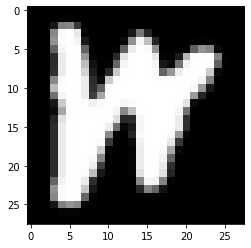

In [6]:
# print classes
print(train_set.classes)
classes = train_set.classes
# print label
index = 0
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

### Collected Data

In [90]:
letter_to_label = dict()
classes_collected = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes_collected)):
    letter_to_label[classes_collected[i]] = i
print(letter_to_label)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}


In [92]:
# making a dataset of our data
import os
import shutil
import glob

from PIL import Image
import torchvision.transforms as transforms

transform = transforms.ToTensor()

src_dir = 'dataset'
imgs = []
labels = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    labels.append(letter_to_label[letter])
    im = Image.open(f).convert('L')
    imgs.append(transform(im).detach().numpy())
data = torch.tensor(imgs)
labels = np.array(labels)

print(data.shape)
print(labels.shape)

torch.Size([364, 1, 28, 28])
(364,)


In [93]:
# shuffling the data
ntotal = data.shape[0]
ntrain = int(0.7*ntotal)
nval = (ntotal - ntrain) // 2

indices = torch.randperm(ntotal)
data = data[indices]
labels = torch.tensor(labels[indices])



batch_size = 64
train_set_collected = torch.utils.data.TensorDataset(data[:ntrain], labels[:ntrain])
val_set_collected = torch.utils.data.TensorDataset(data[ntrain:ntrain+nval], labels[ntrain:ntrain+nval])
test_set_collected = torch.utils.data.TensorDataset(data[ntrain+nval:], labels[ntrain+nval:])

train_loader_collected = torch.utils.data.DataLoader(train_set_collected, batch_size=batch_size)
val_loader_collected = torch.utils.data.DataLoader(val_set_collected, batch_size=batch_size)
test_loader_collected = torch.utils.data.DataLoader(test_set_collected, batch_size=batch_size)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: k


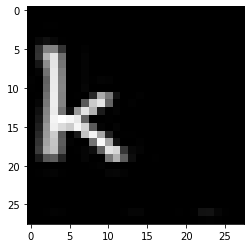

In [94]:
# print classes
print(classes_collected)
# print label
index = 0
plt.imshow(data[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels[index].item()])

## Testing CNNs

In [31]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

def display_contingency_matrix(num_classes, pred, true):
    contingency = np.zeros((num_classes, num_classes))
    for i in range(len(pred)):
        contingency[int(pred[i])][int(true[i])] += 1

    plt.matshow(contingency)
    plt.xlabel("true")
    plt.ylabel("predictions")
    plt.colorbar()

### Single Convolution Layer with MaxPool

In [34]:
class modelCM(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [35]:
model1 = modelCM(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=.001)
train_network(model1, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.98078
   Val loss: 0.58957

EPOCH 1
 Train loss: 0.52378
   Val loss: 0.46848

EPOCH 2
 Train loss: 0.43910
   Val loss: 0.43008

EPOCH 3
 Train loss: 0.39566
   Val loss: 0.40402

EPOCH 4
 Train loss: 0.36528
   Val loss: 0.41254

EPOCH 5
 Train loss: 0.34225
   Val loss: 0.38645

EPOCH 6
 Train loss: 0.32329
   Val loss: 0.38580

EPOCH 7
 Train loss: 0.30687
   Val loss: 0.36336

EPOCH 8
 Train loss: 0.29509
   Val loss: 0.36017

EPOCH 9
 Train loss: 0.28236
   Val loss: 0.35651



Test accuracy: 88.630


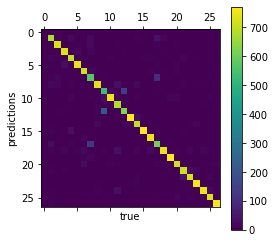

In [36]:
acc, true, pred = test_network(model1, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1.classes), pred, true)

### Smaller Kernel Size

In [75]:
class modelCMS(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1352, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [76]:
model1s = modelCMS(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1s.parameters(), lr=.001)
train_network(model1s, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.17019
   Val loss: 0.87196

EPOCH 1
 Train loss: 0.75781
   Val loss: 0.66895

EPOCH 2
 Train loss: 0.60232
   Val loss: 0.55976

EPOCH 3
 Train loss: 0.52092
   Val loss: 0.50821

EPOCH 4
 Train loss: 0.46934
   Val loss: 0.48267

EPOCH 5
 Train loss: 0.43284
   Val loss: 0.46089

EPOCH 6
 Train loss: 0.40675
   Val loss: 0.43168

EPOCH 7
 Train loss: 0.38466
   Val loss: 0.42446

EPOCH 8
 Train loss: 0.36922
   Val loss: 0.42302

EPOCH 9
 Train loss: 0.35414
   Val loss: 0.41236



Test accuracy: 87.226


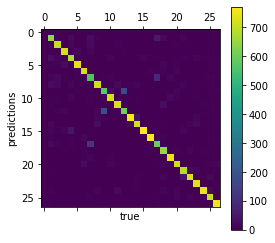

In [77]:
acc, true, pred = test_network(model1s, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1s.classes), pred, true)

### Double Convolution Layer with MaxPool

In [45]:
class modelCMCM(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [46]:
model2 = modelCMCM(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=.001)
train_network(model2, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.77006
   Val loss: 0.41445

EPOCH 1
 Train loss: 0.36632
   Val loss: 0.32226

EPOCH 2
 Train loss: 0.29433
   Val loss: 0.28229

EPOCH 3
 Train loss: 0.25509
   Val loss: 0.27285

EPOCH 4
 Train loss: 0.22714
   Val loss: 0.26959

EPOCH 5
 Train loss: 0.20399
   Val loss: 0.25221

EPOCH 6
 Train loss: 0.18908
   Val loss: 0.25285

EPOCH 7
 Train loss: 0.17471
   Val loss: 0.24559

EPOCH 8
 Train loss: 0.16109
   Val loss: 0.25757

EPOCH 9
 Train loss: 0.15092
   Val loss: 0.25095



Test accuracy: 91.731


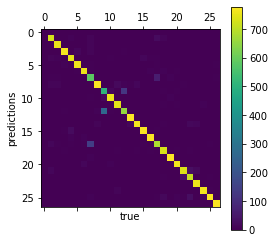

In [47]:
acc, true, pred = test_network(model2, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model2.classes), pred, true)

### Single Convolution Network with Average Pool

In [50]:
class modelCA(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [51]:
model3 = modelCA(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=.001)
train_network(model3, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.03406
   Val loss: 0.67501

EPOCH 1
 Train loss: 0.58105
   Val loss: 0.50578

EPOCH 2
 Train loss: 0.46979
   Val loss: 0.44624

EPOCH 3
 Train loss: 0.41805
   Val loss: 0.42677

EPOCH 4
 Train loss: 0.38483
   Val loss: 0.40216

EPOCH 5
 Train loss: 0.36400
   Val loss: 0.39014

EPOCH 6
 Train loss: 0.34545
   Val loss: 0.39620

EPOCH 7
 Train loss: 0.33108
   Val loss: 0.38203

EPOCH 8
 Train loss: 0.31981
   Val loss: 0.37706

EPOCH 9
 Train loss: 0.30758
   Val loss: 0.37701



Test accuracy: 87.885


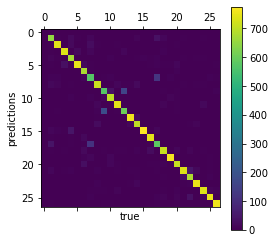

In [52]:
acc, true, pred = test_network(model3, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model3.classes), pred, true)

## Visualizing Optimized Inputs

In [53]:
class OptimizeInput(nn.Module):
    def __init__(self, learned_model, input_shape=(1, 1, 28, 28)):
        super().__init__()
        self.learned_model = learned_model
        self.optimized_input = torch.zeros(input_shape, requires_grad=True)
        
    def forward(self):
        return self.learned_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [104]:
# Given model, get optimized input for each character
def get_optimized_inputs(model, nepochs = 10000):
    targets = torch.arange(len(model.classes)).long()
    optimized_inputs = {}

    for t in targets:
        # train input
        input_model = OptimizeInput(model)
        optimizer = torch.optim.Adam(input_model.parameters(), lr=.01)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(nepochs):
            optimizer.zero_grad()
            outputs = input_model()
            loss = criterion(outputs, t.reshape(1))
            loss.backward()
            optimizer.step()
        print("finished %s with %0.5f loss" % (model.classes[t], loss.item()), end = "\t")
        optimized_inputs[model.classes[t]] = input_model.optimized_input.detach().numpy().reshape((28, 28))
        
        # test input
        tensor = torch.Tensor(optimized_inputs[model.classes[t]].reshape(1, 1, 28, 28))
        with torch.no_grad():
            output = model(tensor)
        prob = output.squeeze().detach().numpy()
        pred = model.classes[torch.argmax(output, dim=1)]
        print(f"Expected: {model.classes[t]}. Predicted: {pred}.")
    return optimized_inputs

In [105]:
optimized_inputs = get_optimized_inputs(model2, nepochs=1000)

finished N/A with 0.30625 loss	Expected: N/A. Predicted: N/A.
finished a with 0.00019 loss	Expected: a. Predicted: a.
finished b with 0.00020 loss	Expected: b. Predicted: b.
finished c with 0.00013 loss	Expected: c. Predicted: c.
finished d with 0.00023 loss	Expected: d. Predicted: d.
finished e with 0.00016 loss	Expected: e. Predicted: e.
finished f with 0.00009 loss	Expected: f. Predicted: f.
finished g with 0.00018 loss	Expected: g. Predicted: g.
finished h with 0.00012 loss	Expected: h. Predicted: h.
finished i with 0.00016 loss	Expected: i. Predicted: i.
finished j with 0.00014 loss	Expected: j. Predicted: j.
finished k with 0.00015 loss	Expected: k. Predicted: k.
finished l with 0.00027 loss	Expected: l. Predicted: l.
finished m with 0.00011 loss	Expected: m. Predicted: m.
finished n with 0.00017 loss	Expected: n. Predicted: n.
finished o with 0.00032 loss	Expected: o. Predicted: o.
finished p with 0.00011 loss	Expected: p. Predicted: p.
finished q with 0.00011 loss	Expected: q. 

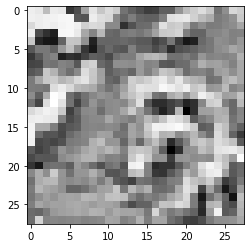

In [109]:
letter = 'b'
letter_visualized = optimized_inputs[letter].T
plt.imshow(letter_visualized, cmap='Greys_r')